# mESC analysis using Cyclum with Auto Tuning

We still use the mESC dataset. For simplicity we have converted the dataset into TPM.
The original count data is available at ArrayExpress: [E-MTAB-2805](https://www.ebi.ac.uk/arrayexpress/experiments/E-MTAB-2805/). Tools to transform data are also provided and explained in the following sections.

In [ ]:
# Add ../../ to path
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 

## Import necessary packages

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 1

In [2]:
import pandas as pd
import numpy as np
import sklearn as skl

In [3]:
import cyclum.tuning
import cyclum.models
from cyclum import writer


Using TensorFlow backend.


## Read data
Here we have label, so we load both. However, the label is not used until evaluation.

In [4]:
input_file_mask = '/home/shaoheng/Documents/data/mESC/mesc-tpm'

def preprocess(input_file_mask):
    """
    Read in data and perform log transform (log2(x+1)), centering (mean = 1) and scaling (sd = 1).
    """
    tpm = writer.read_df_from_binary(input_file_mask).T
    sttpm = pd.DataFrame(data=skl.preprocessing.scale(np.log2(tpm.values + 1)), index=tpm.index, columns=tpm.columns)
    
    label = pd.read_csv(input_file_mask + '-label.txt', sep="\t", index_col=0).T
    return sttpm, label

sttpm, label = preprocess(input_file_mask)

In [5]:
sttpm.shape

(288, 38293)

There is no convention whether cells should be columns or rows. Here we require cells to be rows.

## Set up the model and fit the model

In [6]:
model = cyclum.tuning.CyclumAutoTune(sttpm, max_linear_dims=5, 
                                     epochs=500, rate=2e-4, verbose=100,
                                     encoder_width=[30, 20])

Auto tuning number of linear components...
Performing PCA...
Training Autoencoder with...
    0 linear dimensions...




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


epoch: 100/500, loss:  0.7162, time elapsed:  35.26s, time left:  141.03s
epoch: 200/500, loss:  0.7093, time elapsed:  68.30s, time left:  102.45s
epoch: 300/500, loss:  0.7061, time elapsed:  100.07s, time left:  66.72s
epoch: 400/500, loss:  0.7047, time elapsed:  131.67s, time left:  32.92s
epoch: 500/500, loss:  0.7041, time elapsed:  163.12s, time left:  0.00s
[0.7040824558999803]
[0.683471149628097, 0.6739115545490159, 0.6668004262298473, 0.6607528323259702, 0.6550283023863888, 0.6501622374829168]
    1 linear dimensions...
epoch: 100/500, loss:  0.6775, time elapsed:  32.51s, time left:  130.04s
epoch: 200/500, loss:  0.6744, time elapsed:  64.71s, time left:  97.06s
epoch: 300/500, loss:  0.6727, time elapsed:  96.88s, time left:  64.59s
epoch

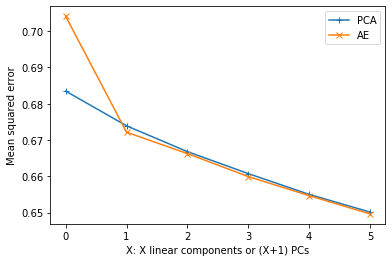

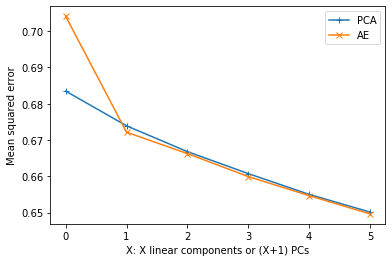

In [7]:
model.show_elbow()

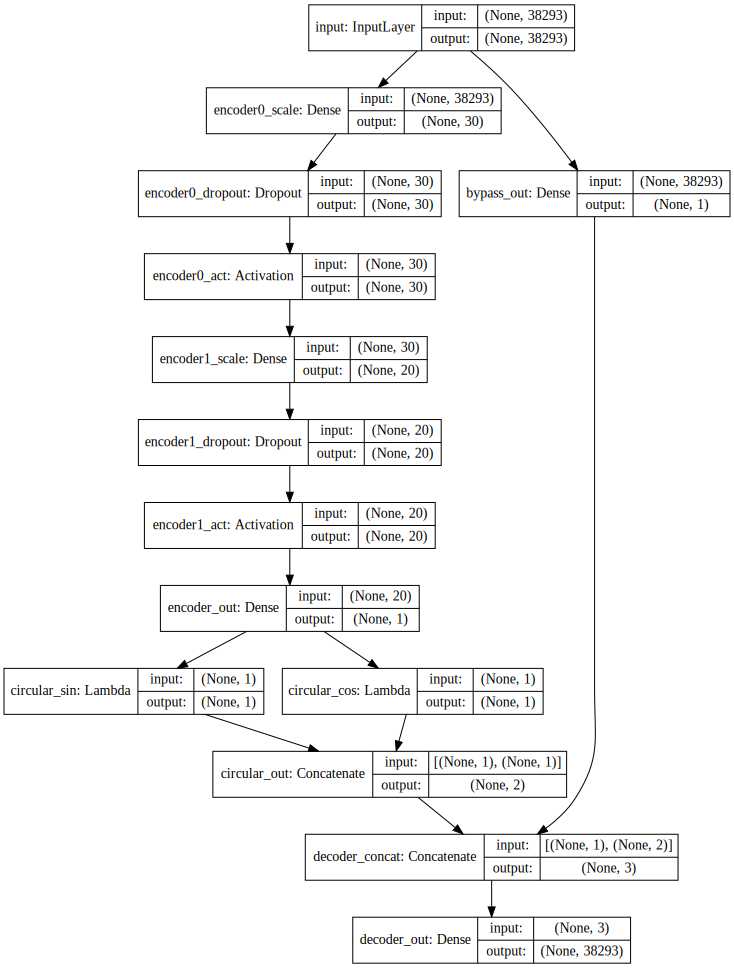

In [8]:
display(model.show_structure())


In [9]:
model.train(sttpm, epochs=800, verbose=100, rate=2e-4)

epoch: 100/800, loss:  0.6772, time elapsed:  34.22s, time left:  239.57s
epoch: 200/800, loss:  0.6737, time elapsed:  68.09s, time left:  204.28s
epoch: 300/800, loss:  0.6727, time elapsed:  102.87s, time left:  171.45s
epoch: 400/800, loss:  0.6722, time elapsed:  135.42s, time left:  135.42s
epoch: 500/800, loss:  0.6718, time elapsed:  167.92s, time left:  100.75s
epoch: 600/800, loss:  0.6720, time elapsed:  200.44s, time left:  66.81s
epoch: 700/800, loss:  0.6716, time elapsed:  232.92s, time left:  33.27s
epoch: 800/800, loss:  0.6718, time elapsed:  265.52s, time left:  0.00s


In [10]:
pseudotime = model.predict_pseudotime(sttpm)

## Illustrations
We illustrate the results on a circle, to show its circular nature. 
There is virtually no start and end of the circle.
Red, green and blue represents G0/G1, S and G2/M phase respectively.
The inner lines represents single cells. The cells spread across the
The areas outside

In [11]:
import cyclum.illustration

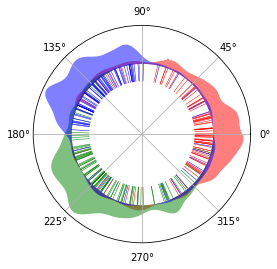

In [12]:
color_map = {'stage': {"g0/g1": "red", "s": "green", "g2/m": "blue"},
                 'subcluster': {"intact": "cyan", "perturbed": "violet"}}
cyclum.illustration.plot_round_distr_color(pseudotime, label['stage'], color_map['stage'])
pass


In [13]:
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error as mse

pca_model = PCA(n_components=5)
pca_load = pca_model.fit_transform(sttpm)
pca_comp = pca_model.components_

pca_loss = [mse(sttpm, pca_load[:, 0:(i+1)] @ pca_comp[0:(i+1), :]) for i in range(5)]
print(pca_loss)


[0.6834711496280971, 0.6739115544668258, 0.6668004141731773, 0.6607522087516757, 0.6550269134565108]


In [14]:
model.save("/home/shaoheng/Documents/data/mESC/model.h5")

In [17]:
from cyclum.hdfrw import mat2hdf
mat2hdf(pseudotime, '/home/shaoheng/Documents/data/EMTAB2805/cyclum-pseudotime.h5')

In [16]:
mat2hdf(sttpm, '/home/shaoheng/Documents/data/EMTAB2805/sttpm.h5')